In [1]:
import pandas as pd
import numpy as np
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt


In [2]:
data=pd.read_csv(r'C:\Users\kiran\OneDrive\Desktop\Shreya\KRR\books.csv')

In [3]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'ProductCategory' is a categorical column in your dataset
le = LabelEncoder()
data['Gender'] = le.fit_transform(data['Gender']) 
data['NewPrice']= 0
data= data.drop('ProductCategory', axis=1)

In [4]:
data.head()

,Age,Gender,ProductPrice,ProductCost,Profit,FootTraffic,InventoryLevel,CompetitorPrice,PurchaseMonth,PurchaseQuarter,DayOfWeek,ProductType,NewPrice
0,34,1,148.49,136.61,11.88,832,96,148.48,5,2,3,8,0
1,29,0,148.63,114.45,34.18,737,62,162.24,3,1,3,1,0
2,60,0,459.73,445.94,13.79,545,75,423.86,2,1,4,3,0
3,67,0,247.45,247.45,0.00,495,67,266.17,2,1,5,9,0
4,40,1,229.88,172.41,57.47,183,89,232.24,9,3,3,9,0


In [5]:
state_features = ['Age', 'Gender', 'ProductPrice', 'ProductCost', 'Profit', 'FootTraffic', 'InventoryLevel', 'CompetitorPrice', 'PurchaseMonth', 'PurchaseQuarter', 'DayOfWeek','ProductType','NewPrice']
actions = [0.05, 0.1, -0.05, -0.1]

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Assuming your dataset is stored in a DataFrame named 'data'
# and you want to normalize all columns

# Extract numerical columns (you might need to adjust this based on your data)
numerical_columns = data.select_dtypes(include=[np.number]).columns.tolist()

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the numerical columns
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])


In [7]:
# Function to calculate reward for a given action
def calculate_reward_for_action(state, action, competitor_price_threshold=0.05, product_price_threshold=0.1):
   
    # Assuming 'ProductPrice' is at index 2 in the state array
    product_price_index = 2
    new_price_index=12
    penalty=0
    # Calculate new product price based on the action
    state[new_price_index] = state[product_price_index] * (1 + float(action))
    
    # Calculate profit
    profit = state[new_price_index] - state[3]  # Assuming 'ProductCost' is at index 4 in the state array
    
    # Check proximity to competitor price
    if abs(state[new_price_index] - state[7]) < competitor_price_threshold * state[7]:  # Assuming 'CompetitorPrice' is at index 8
        # Apply penalty for being near competitor price
        penalty= -5 # Assuming 'ProductCost' is at index 4
    
    # Check proximity to original product price
    if abs(state[new_price_index] - state[2]) < product_price_threshold * state[2]:
        # Apply penalty for being near original product price
        penalty =-3 # Assuming 'ProductCost' is at index 4
        
#     if state[new_price_index] < 1.3* state[product_price_index]:
#         state[product_price_index]= state[new_price_index]
        
    reward=(profit-penalty)/2
    state[product_price_index]= state[new_price_index]
    return reward

In [8]:
data.shape

(36, 13)

In [9]:
# Generate synthetic dataset
synthetic_data = []

for index, row in data.iterrows():
    state = row[state_features]
    
    for action in actions:
        next_state = state.copy()
        next_state['ProductPrice'] *= (1 + action)
        
        reward = calculate_reward_for_action(state, action)
        
        sample = {
            'state': state.tolist(),
            'action': action,
            'next_state': next_state.tolist(),
            'reward': reward
        }
        
        synthetic_data.append(sample)

# Convert the list of dictionaries to a DataFrame
syndf = pd.DataFrame(synthetic_data, columns=['state', 'action', 'next_state', 'reward'])


In [10]:
syndf.shape

(144, 4)

In [11]:


class ReplayMemory:
    def __init__(self):
        self.capacity = 1000  # You can adjust the capacity if needed
        self.memory = []

    def push(self, transition):
        if len(self.memory) >= self.capacity:
            self.memory.pop(0)
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

# Initialize replay memory
replay_memory = ReplayMemory()




In [12]:
# Define epsilon-greedy exploration
def epsilon_greedy_action_selection(model, state, actions, epsilon):
    if np.random.rand() < epsilon:
        # Exploration: Choose a random action
        action = np.random.choice(actions)
    else:
        # Exploitation: Choose the action with the highest Q-value
        q_values = model.predict(np.array([state]))
        action = actions[np.argmax(q_values)]
    return action

In [13]:
# Extract state, action, next_state, and reward
states = np.array(syndf['state'].tolist())
actions = np.array(syndf['action'])
next_states = np.array(syndf['next_state'].tolist())
rewards = np.array([calculate_reward_for_action(states[i], actions[i]) for i in range(len(actions))])


In [14]:
from keras.optimizers import Adam

# Define the DQN model
model = Sequential()
model.add(Dense(64, input_shape=(len(state_features),), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(actions), activation='linear'))  # Output layer

# Compile the model with a specific learning rate
custom_optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate as needed
model.compile(optimizer=custom_optimizer, loss='mse')

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Training the DQN
history=model.fit(states, rewards, epochs=20, batch_size=32, validation_split=0.2)

# Print the training history
print(history.history)



Epoch 1/20

4/4 [==============================] - 8s 647ms/step - loss: 1.5988 - val_loss: 2.0304
Epoch 2/20
4/4 [==============================] - 0s 114ms/step - loss: 1.5128 - val_loss: 1.9131
Epoch 3/20
4/4 [==============================] - 1s 190ms/step - loss: 1.4262 - val_loss: 1.7724
Epoch 4/20
4/4 [==============================] - 1s 180ms/step - loss: 1.3162 - val_loss: 1.6002
Epoch 5/20
4/4 [==============================] - 0s 99ms/step - loss: 1.1831 - val_loss: 1.3966
Epoch 6/20
4/4 [==============================] - 0s 66ms/step - loss: 1.0428 - val_loss: 1.1769
Epoch 7/20
4/4 [==============================] - 0s 68ms/step - loss: 0.9034 - val_loss: 0.9865
Epoch 8/20
4/4 [==============================] - 0s 90ms/step - loss: 0.7892 - val_loss: 0.8582
Epoch 9/20
4/4 [==============================] - 0s 94ms/step - loss: 0.7143 - val_loss: 0.7821
Epoch 10/20
4/4 [==============================] - 0s 58ms/step - loss: 0.6728 - val_loss: 0.7295
Epoch 11/20
4/4 [=====

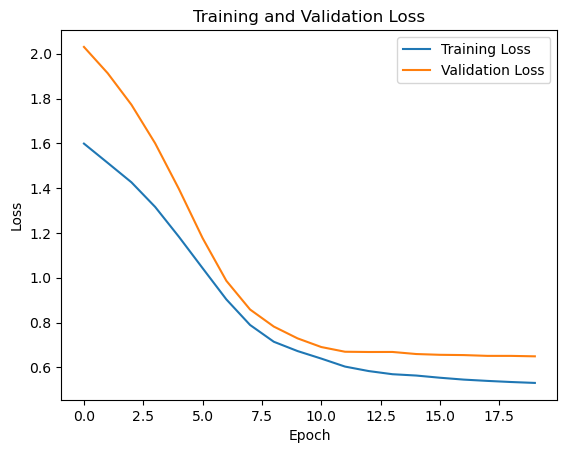

In [15]:
# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [16]:
# Target Network
target_model = Sequential()
target_model.add(Dense(64, input_shape=(len(states[0]),), activation='relu'))
target_model.add(Dense(64, activation='relu'))
target_model.add(Dense(len(actions), activation='linear'))
target_model.compile(optimizer='adam', loss='mse')
target_model.set_weights(model.get_weights())  # Initialize target network with current model weights
epoch_rewards=[]


In [17]:
# Initialize epsilon and decay parameters
epsilon = 0.1  # Initial epsilon value, you can adjust this
epsilon_decay = 0.99  # Decay factor for epsilon, adjust as needed

epoch_rewards = []
cumulative_rewards = []  # Store cumulative rewards over epochs

for e in range(20):
    total_epoch_reward = 0
    
    for i in range(len(actions)):
        state = states[i]
        action = epsilon_greedy_action_selection(model, state, actions, epsilon)
        reward = calculate_reward_for_action(state, action)
        next_state = next_states[i]

        replay_memory.push((state, action, reward, next_state))

        # Sample a random mini-batch from replay memory
        batch_size = 32
        if len(replay_memory.memory) >= batch_size:
            transitions = replay_memory.sample(batch_size)
            batch_states, batch_actions, batch_rewards, batch_next_states = zip(*transitions)

            target_q_values = target_model.predict(np.array(batch_next_states))
            max_target_q_values = np.max(target_q_values, axis=1)
            target_q_values_for_actions = batch_rewards + 0.99 * max_target_q_values

            model.fit(np.array(batch_states), target_q_values_for_actions, epochs=1, verbose=0)

    if e % 5 == 0:
        target_model.set_weights(model.get_weights())

    epoch_reward = np.sum([calculate_reward_for_action(states[i], actions[i]) for i in range(len(actions))])
    epoch_rewards.append(epoch_reward)
    cumulative_rewards.append(np.sum(epoch_rewards))  # Calculate cumulative reward

    # Print the reward gained and cumulative reward in this epoch
    print(f'Epoch {e + 1} - Reward: {epoch_reward} - Cumulative Reward: {cumulative_rewards[-1]}')

    # Decay epsilon
    epsilon *= epsilon_decay




1/1 [==============================] - 0s 162ms/step
Epoch 1 - Reward: 154.500791797408 - Cumulative Reward: 154.500791797408
1/1 [==============================] - 0s 135ms/step
Epoch 2 - Reward: 148.01679516986547 - Cumulative Reward: 302.5175869672735
1/1 [==============================] - 0s 144ms/step
Epoch 3 - Reward: 149.94006020626497 - Cumulative Reward: 452.4576471735385
1/1 [==============================] - 0s 103ms/step
Epoch 4 - Reward: 154.96034248760287 - Cumulative Reward: 607.4179896611413
1/1 [==============================] - 0s 157ms/step
Epoch 5 - Reward: 145.58598045525417 - Cumulative Reward: 753.0039701163955
1/1 [==============================] - 0s 126ms/step
Epoch 6 - Reward: 149.42250391809597 - Cumulative Reward: 902.4264740344915
1/1 [==============================] - 0s 97ms/step
Epoch 7 - Reward: 159.20181191306995 - Cumulative Reward: 1061.6282859475614
1/1 [==============================] - 0s 88ms/step
Epoch 8 - Reward: 154.16974253040843 - Cumulativ

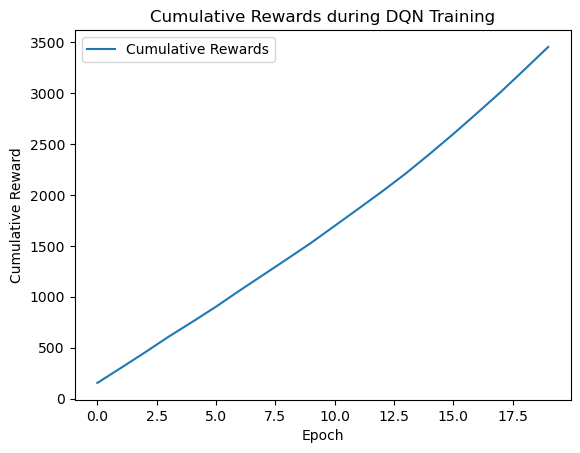

In [18]:
# Plot the cumulative rewards
plt.plot(cumulative_rewards, label='Cumulative Rewards')
plt.xlabel('Epoch')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Rewards during DQN Training')
plt.legend()
plt.show()

In [19]:
epoch_rewards

[154.500791797408,
 148.01679516986547,
 149.94006020626497,
 154.96034248760287,
 145.58598045525417,
 149.42250391809597,
 159.20181191306995,
 154.16974253040843,
 154.99419073965214,
 156.97495933829333,
 167.51743042597676,
 168.0493050987879,
 169.9363149081641,
 176.86960871425364,
 190.4443859841827,
 196.51770922363954,
 204.4997012156893,
 207.73853662795017,
 219.80321186951625,
 222.33025384215432]

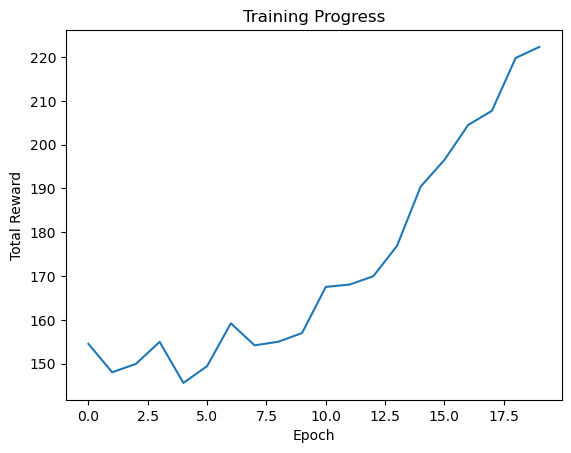

In [20]:
import matplotlib.pyplot as plt
# Plotting the training progress
plt.plot(epoch_rewards)
plt.xlabel('Epoch')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.show()

# Q Learning


In [21]:
import numpy as np
import pandas as pd
import random

# Define the Q-learning algorithm
class QLearningAgent:
    def __init__(self, actions, learning_rate=0.001, discount_factor=0.99, exploration_prob=0.5):
        self.actions = actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_prob = exploration_prob
        self.q_values = {}

    def get_q_value(self, state, action):
        return self.q_values.get((tuple(state), action), 0.0)

    def update_q_value(self, state, action, reward, next_state):
        best_next_action = max(self.actions, key=lambda a: self.get_q_value(next_state, a))
        new_q_value = (1 - self.learning_rate) * self.get_q_value(state, action) + \
                      self.learning_rate * (reward + self.discount_factor * self.get_q_value(next_state, best_next_action))
        self.q_values[(tuple(state), action)] = new_q_value

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_prob:
            return random.choice(self.actions)
        else:
            return max(self.actions, key=lambda a: self.get_q_value(state, a))

# Initialize Q-learning agent
q_learning_agent = QLearningAgent(actions)



Epoch 1 - Total Reward: 155.94487050003175
Epoch 2 - Total Reward: 149.85677218427134
Epoch 3 - Total Reward: 147.03830050455986
Epoch 4 - Total Reward: 150.49334899130432
Epoch 5 - Total Reward: 145.22810515968575
Epoch 6 - Total Reward: 148.25108888124808
Epoch 7 - Total Reward: 154.073212689629
Epoch 8 - Total Reward: 152.2078644027426
Epoch 9 - Total Reward: 150.1710126605454
Epoch 10 - Total Reward: 161.98133619816764
Epoch 11 - Total Reward: 159.16037790081688
Epoch 12 - Total Reward: 165.7327249216745
Epoch 13 - Total Reward: 168.22621638925492
Epoch 14 - Total Reward: 171.1721804887312
Epoch 15 - Total Reward: 170.1057029749994
Epoch 16 - Total Reward: 181.56592946631721
Epoch 17 - Total Reward: 186.0964041789544
Epoch 18 - Total Reward: 195.7454480983168
Epoch 19 - Total Reward: 204.5665799435899
Epoch 20 - Total Reward: 214.11898367439198


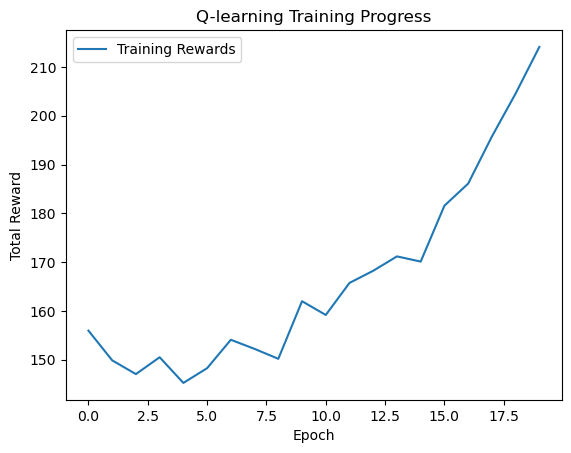

In [22]:


# Q-learning training
training_rewards = []

for epoch in range(20):
    total_reward = 0
    for i in range(len(synthetic_data)):
        state = synthetic_data[i]['state']
        action = synthetic_data[i]['action']
        reward = calculate_reward_for_action(state, action)
        next_state = synthetic_data[i]['next_state']

        # Update Q-values
        q_learning_agent.update_q_value(state, action, reward, next_state)

        total_reward += reward

    training_rewards.append(total_reward)
    print(f'Epoch {epoch + 1} - Total Reward: {total_reward}')

# Plot the training rewards
plt.plot(training_rewards, label='Training Rewards')
plt.xlabel('Epoch')
plt.ylabel('Total Reward')
plt.title('Q-learning Training Progress')
plt.legend()
plt.show()
